In [ ]:
# Import all Required Libs
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import zipfile


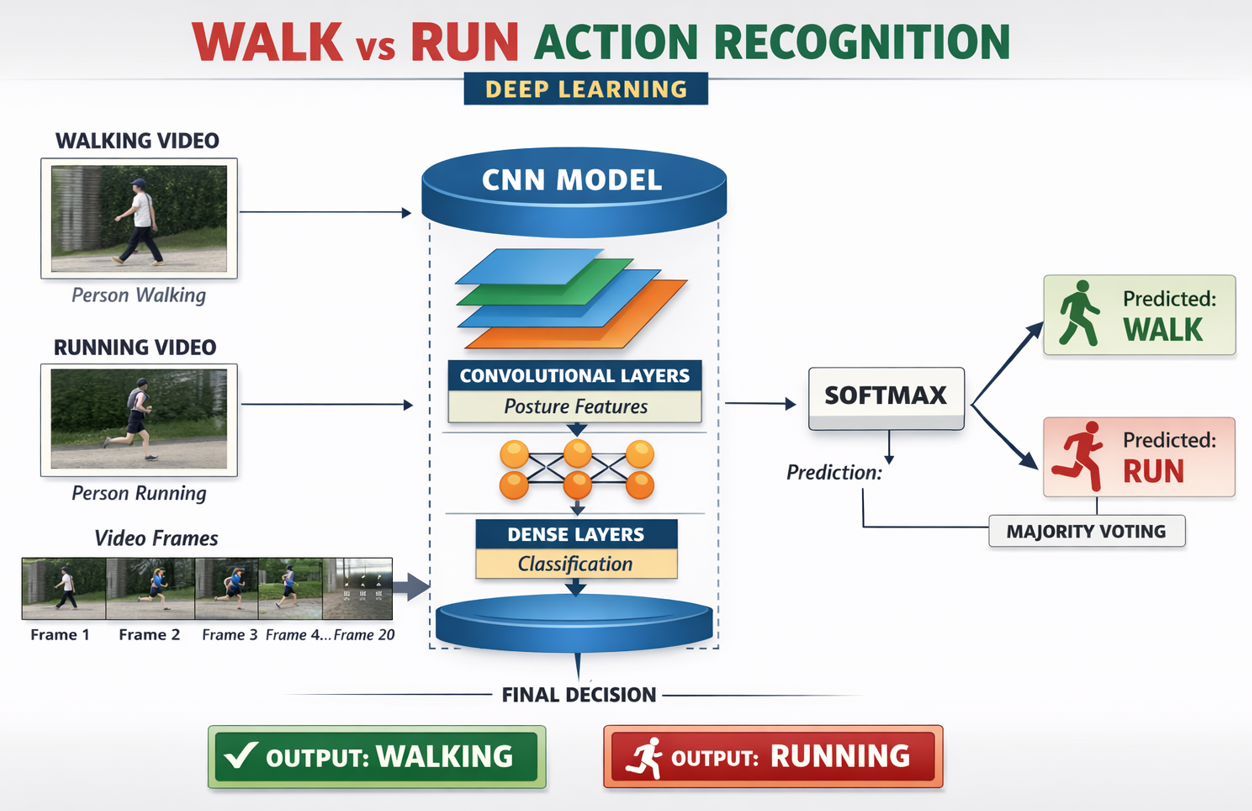

In [ ]:
!wget https://www.csc.kth.se/cvap/actions/walking.zip

--2026-01-12 08:31:27--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.57, 2001:6b0:1:11c2::82ed:1c39
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M   849KB/s    in 4m 42s  

2026-01-12 08:36:11 (840 KB/s) - ‘walking.zip’ saved [242442411/242442411]



In [ ]:
!wget https://www.csc.kth.se/cvap/actions/running.zip

--2026-01-12 08:36:11--  https://www.csc.kth.se/cvap/actions/running.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.57, 2001:6b0:1:11c2::82ed:1c39
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149756643 (143M) [application/zip]
Saving to: ‘running.zip’

running.zip         100%[===================>] 142.82M   880KB/s    in 2m 53s  

2026-01-12 08:39:05 (846 KB/s) - ‘running.zip’ saved [149756643/149756643]



In [ ]:
with zipfile.ZipFile("walking.zip","r") as zip_ref:
    zip_ref.extractall("/content/walking")

In [ ]:
with zipfile.ZipFile("running.zip","r") as zip_ref:
    zip_ref.extractall("/content/running")

In [ ]:
# Read Video using Tensorflow
img_size=120
max_frames=20
def load_video(video_path):
  frames = []
  cap = cv2.VideoCapture(video_path)
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = cv2.resize(frame, (img_size, img_size))
      frame = frame / 255.0  # Normalize to [0, 1]
      frames.append(frame)
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return tf.convert_to_tensor(frames, dtype=tf.float32)

In [ ]:
X,y=[],[]
for label,folder in enumerate(['walking','running']):
    folder_path = os.path.join('/content', folder)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.avi'):
            video_path = os.path.join(folder_path, file_name)
            frames = load_video(video_path)
            X.append(frames)
            y.append(label)
X=tf.keras.preprocessing.sequence.pad_sequences(X,padding='post')
y=tf.keras.utils.to_categorical(y,2)
print(X.shape)
print(y.shape)

(200, 20, 120, 120, 3)
(200, 2)


In [ ]:
#creating Model and adding Layers
model=Sequential(
    [
        TimeDistributed(Conv2D(32,kernel_size=(3,3),activation='relu'),input_shape=(max_frames,img_size,img_size,3)),
        TimeDistributed(MaxPooling2D(pool_size=(2,2))),

        TimeDistributed(Conv2D(64,kernel_size=(3,3),activation='relu')),
        TimeDistributed(MaxPooling2D(pool_size=(2,2))),

        TimeDistributed(GlobalAveragePooling2D()),
        Flatten(),
        Dense(128,activation='relu'),

        Dense(2,activation='softmax')


    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 20, 118, 118,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 59, 59, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 57, 57, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,618 (717.26 KB)

 Trainable params: 183,618 (717.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model
model.fit(X, y, epochs=10, batch_size=2)
#

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.5502 - loss: 0.6959
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.4964 - loss: 0.6941
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - accuracy: 0.4501 - loss: 0.6946
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.3983 - loss: 0.6942
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.4792 - loss: 0.6936
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.4635 - loss: 0.6933
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.4675 - loss: 0.6932
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.5271 - loss: 0.6922
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 304s 3s/step - accuracy: 0.4658 - loss: 0.6924
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.5277 - loss: 0.6841
